In [126]:
import socket, sys
socket.gethostname(), sys.executable


('login3', '/project/def-nahee/kbas/pone_offline/graphnet_env/bin/python')

Note: there is a problem related with wrap around thing

# 0. Setup


In [127]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Consistent plotting defaults (no subsampling anywhere in this notebook)
plt.rcParams.update({
    "figure.dpi": 120,
    "savefig.dpi": 300,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "legend.frameon": False,
})


In [128]:
azimuth_test_predictions_path =  Path("../azimuth") / "test_predictions.csv"
azimuth_metrics_path =  Path("../azimuth") / "metrics.csv"
azimuth_resources_and_time_path =  Path("../azimuth") /"resources_and_time.csv"

df_azimuth_test_predictions = pd.read_csv(azimuth_test_predictions_path)
df_azimuth_metrics = pd.read_csv(azimuth_metrics_path)
df_azimuth_resources_and_time = pd.read_csv(azimuth_resources_and_time_path)



# 1. Test Predictions (event-level)


## 1.1 Workflow

a) Confirm schema and NaNs/Infs  
b) Inspect the global residual distribution  
c) Inspect residual vs truth (trend + spread)  
d) Quantify resolution with **W** (equal-width and equal-population bins)  
e) Assess bias (median residual; and where relevant a ratio-based view)


## 1.2 Schema and integrity checks


In [129]:
print("shape:", df_azimuth_test_predictions.shape)
print("columns:", list(df_azimuth_test_predictions.columns))


shape: (41311, 11)
columns: ['true_azimuth_radian', 'pred_azimuth_radian', 'true_azimuth_degree', 'pred_azimuth_degree', 'true_azimuth_degree_signed', 'pred_azimuth_degree_signed', 'pred_azimuth_degree_adj', 'kappa', 'event_id', 'residual_azimuth_radian', 'residual_azimuth_degree']


In [130]:
numeric_cols = df_azimuth_test_predictions.select_dtypes(include=[np.number]).columns
minmax = df_azimuth_test_predictions[numeric_cols].agg(["min", "max"]).T

print(minmax)


                                   min            max
true_azimuth_radian           0.000005       6.282984
pred_azimuth_radian           0.000002       6.283117
true_azimuth_degree           0.000282     359.988495
pred_azimuth_degree           0.000141     359.996094
true_azimuth_degree_signed -179.997925     179.988617
pred_azimuth_degree_signed -179.997192     179.982819
pred_azimuth_degree_adj    -162.502304     532.865295
kappa                         0.013280     165.127792
event_id                     18.000000  402910.000000
residual_azimuth_radian      -3.141270       3.137959
residual_azimuth_degree    -179.981537     179.791794


## 1.3 Column ranges (min / max)


In [131]:
print("Rows:", len(df_azimuth_test_predictions))

print("\nNaN counts (all columns):")
print(df_azimuth_test_predictions.isna().sum())


Rows: 41311

NaN counts (all columns):
true_azimuth_radian           0
pred_azimuth_radian           0
true_azimuth_degree           0
pred_azimuth_degree           0
true_azimuth_degree_signed    0
pred_azimuth_degree_signed    0
pred_azimuth_degree_adj       0
kappa                         0
event_id                      0
residual_azimuth_radian       0
residual_azimuth_degree       0
dtype: int64


In [132]:
# Inf / -Inf counts in numeric columns (auto)
num_df = df_azimuth_test_predictions.apply(pd.to_numeric, errors="coerce")

inf_pos = np.isposinf(num_df).sum()
inf_neg = np.isneginf(num_df).sum()
inf_any = np.isinf(num_df).sum()

out = pd.DataFrame({
    "+inf": inf_pos,
    "-inf": inf_neg,
    "any_inf": inf_any
}).sort_values("any_inf", ascending=False)

print("Inf counts (numeric columns):")
print(out)


Inf counts (numeric columns):
                            +inf  -inf  any_inf
true_azimuth_radian            0     0        0
pred_azimuth_radian            0     0        0
true_azimuth_degree            0     0        0
pred_azimuth_degree            0     0        0
true_azimuth_degree_signed     0     0        0
pred_azimuth_degree_signed     0     0        0
pred_azimuth_degree_adj        0     0        0
kappa                          0     0        0
event_id                       0     0        0
residual_azimuth_radian        0     0        0
residual_azimuth_degree        0     0        0


## 1.4 Global summary (quantiles and W)


In [133]:
# ---- global W over the full test set ----
r = df_azimuth_test_predictions["residual_azimuth_degree"].to_numpy(dtype=float)
p16, p50, p84 = np.quantile(r, [0.16, 0.50, 0.84])
W = (p84 - p16) / 2

print(f"p16={p16:.4f}, p50={p50:.4f}, p84={p84:.4f}, W={W:.4f}")


p16=-5.9289, p50=-0.1462, p84=5.6586, W=5.7937


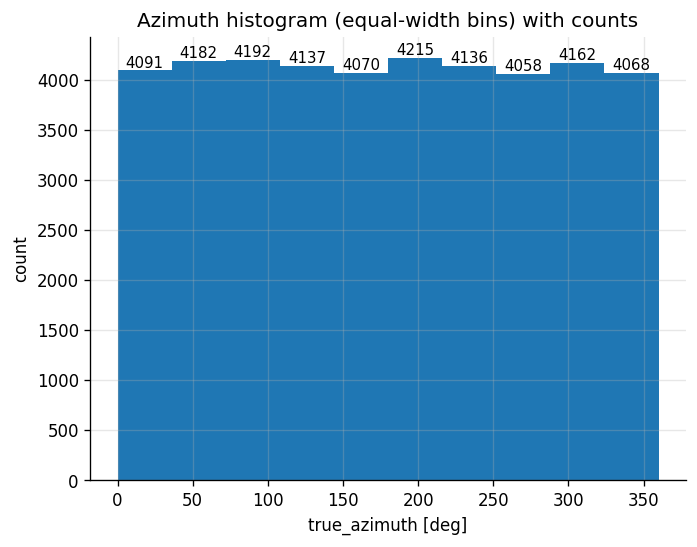

In [134]:
# ---- Azimuth: histogram with counts annotated on top of bars ----
n_bins_azimuth = 10
bins_azimuth = np.linspace(
    df_azimuth_test_predictions["true_azimuth_degree"].min(),
    df_azimuth_test_predictions["true_azimuth_degree"].max(),
    n_bins_azimuth + 1,
)
values = df_azimuth_test_predictions["true_azimuth_degree"].to_numpy(dtype=float)

plt.figure()
counts, edges, patches = plt.hist(values, bins=bins_azimuth)

# annotate each bar with its count
for c, left, right in zip(counts, edges[:-1], edges[1:]):
    if c <= 0:
        continue
    x = 0.5 * (left + right)
    plt.text(x, c, f"{int(c)}", ha="center", va="bottom", fontsize=9)

plt.xlabel("true_azimuth [deg]")
plt.ylabel("count")
plt.title("Azimuth histogram (equal-width bins) with counts")
plt.grid(True, alpha=0.3)
plt.show()



## 1.5 Residual distribution


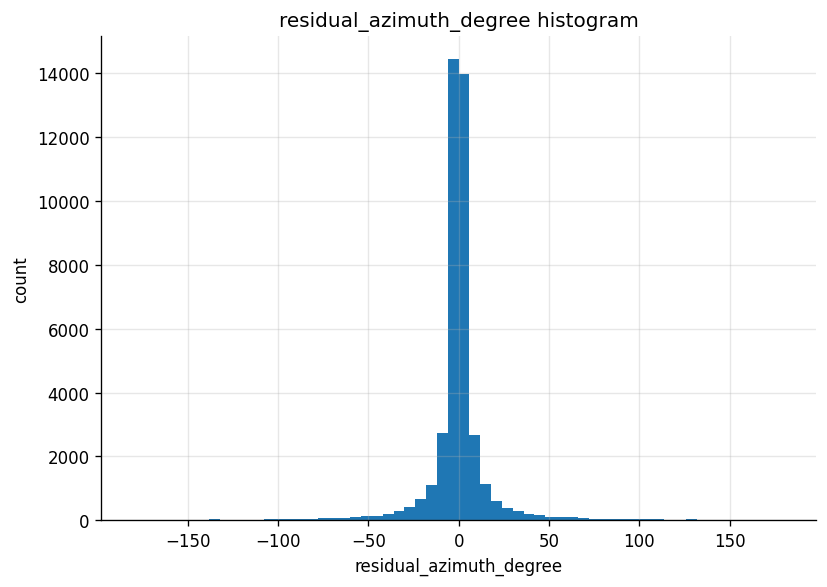

In [135]:

plt.figure(figsize=(7, 5))
plt.hist(r, bins=60)
plt.xlabel("residual_azimuth_degree")
plt.ylabel("count")
plt.title("residual_azimuth_degree histogram")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

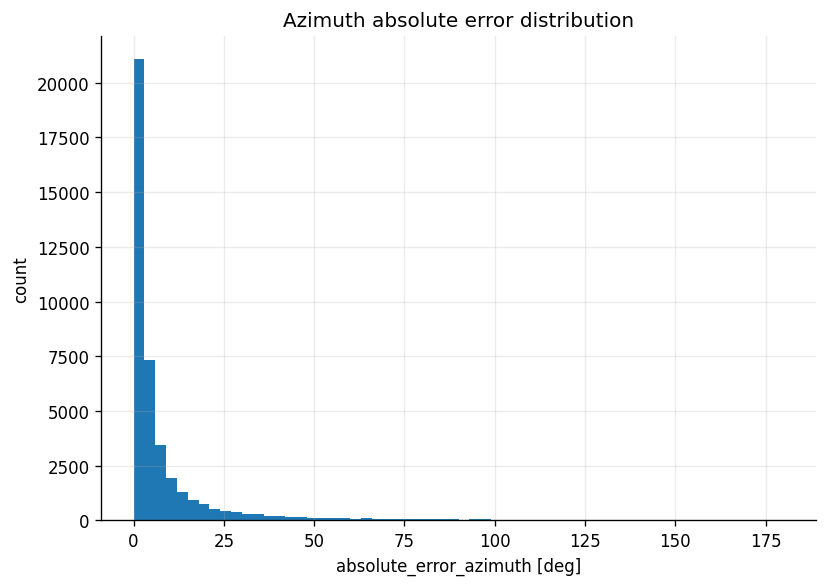

In [136]:
# ---- Absolute error distribution (full test set) ----
abs_err_deg = np.abs(r)

plt.figure(figsize=(7, 5))
plt.hist(abs_err_deg, bins=60)
plt.xlabel("absolute_error_azimuth [deg]")
plt.ylabel("count")
plt.title("Azimuth absolute error distribution")
plt.tight_layout()
plt.show()

## 1.6 Residual vs truth (trend + spread)


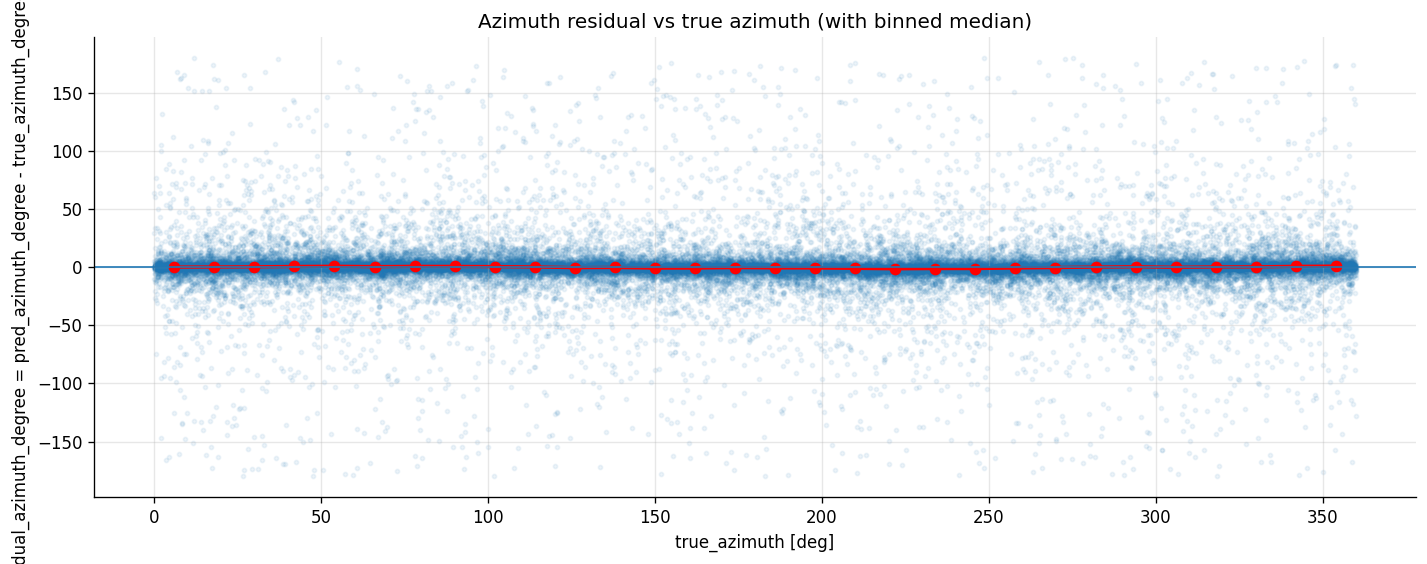

In [137]:
# ---- Azimuth: residual vs true_azimuth scatter + binned median (NO subsample) ----

x = df_azimuth_test_predictions["true_azimuth_degree"].to_numpy(dtype=float)


plt.figure(figsize=(12, 4.8))
plt.scatter(x, r, s=6, alpha=0.08)

# binned median (equal-width in x)
n_bins = 30
bins = np.linspace(x.min(), x.max(), n_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

median_r = []
for left, right in zip(bins[:-1], bins[1:]):
    m = (x >= left) & (x < right) if right != bins[-1] else (x >= left) & (x <= right)
    median_r.append(np.median(r[m]) if np.any(m) else np.nan)

median_r = np.array(median_r, dtype=float)

plt.plot(bin_centers, median_r, marker="o", linewidth=2, color="r")
plt.axhline(0.0, linestyle="-", linewidth=1)

plt.xlabel("true_azimuth [deg]")
plt.ylabel("residual_azimuth_degree = pred_azimuth_degree - true_azimuth_degree [deg]")
plt.title("Azimuth residual vs true azimuth (with binned median)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 1.7 Calibration (predicted vs true)


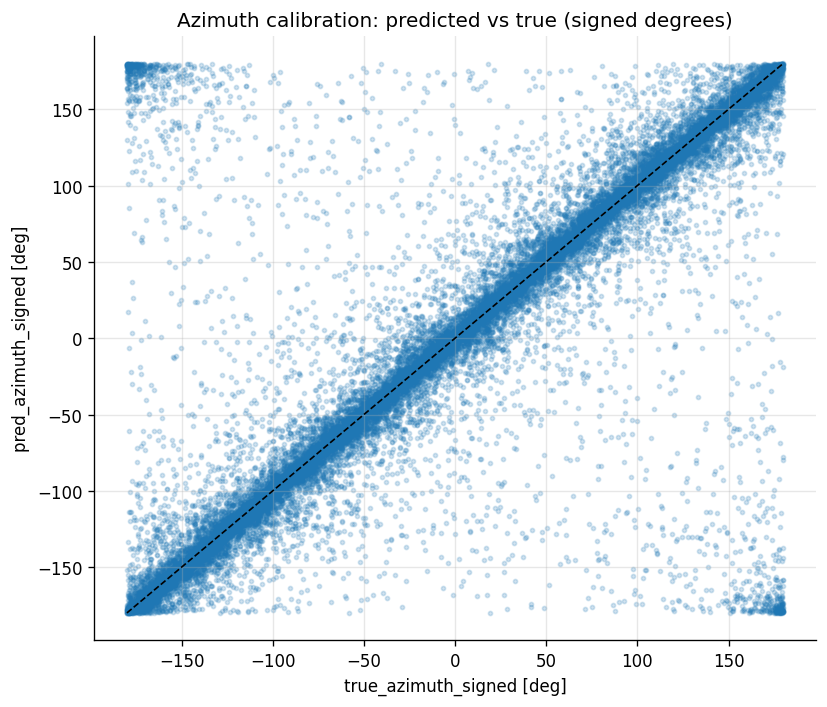

In [138]:
# ---- Azimuth: calibration scatter (SIGNED degree space) ----
plt.figure(figsize=(7, 6))

plt.scatter(
    df_azimuth_test_predictions["true_azimuth_degree_signed"],
    df_azimuth_test_predictions["pred_azimuth_degree_signed"],
    s=6, alpha=0.2
)

xmin = df_azimuth_test_predictions["true_azimuth_degree_signed"].min()
xmax = df_azimuth_test_predictions["true_azimuth_degree_signed"].max()

plt.plot([xmin, xmax], [xmin, xmax], color="black", linestyle="--", linewidth=1)

plt.xlabel("true_azimuth_signed [deg]")
plt.ylabel("pred_azimuth_signed [deg]")
plt.title("Azimuth calibration: predicted vs true (signed degrees)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


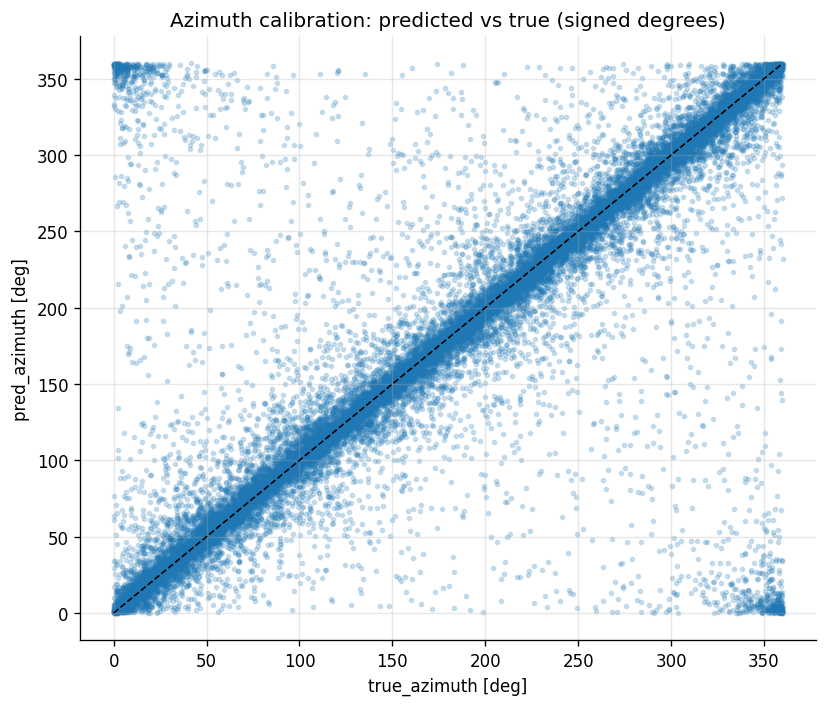

In [139]:
# ---- Azimuth: calibration scatter (SIGNED degree space) ----
plt.figure(figsize=(7, 6))

plt.scatter(
    df_azimuth_test_predictions["true_azimuth_degree"],
    df_azimuth_test_predictions["pred_azimuth_degree"],
    s=6, alpha=0.2
)

xmin = df_azimuth_test_predictions["true_azimuth_degree"].min()
xmax = df_azimuth_test_predictions["true_azimuth_degree"].max()

plt.plot([xmin, xmax], [xmin, xmax], color="black", linestyle="--", linewidth=1)

plt.xlabel("true_azimuth [deg]")
plt.ylabel("pred_azimuth [deg]")
plt.title("Azimuth calibration: predicted vs true (signed degrees)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


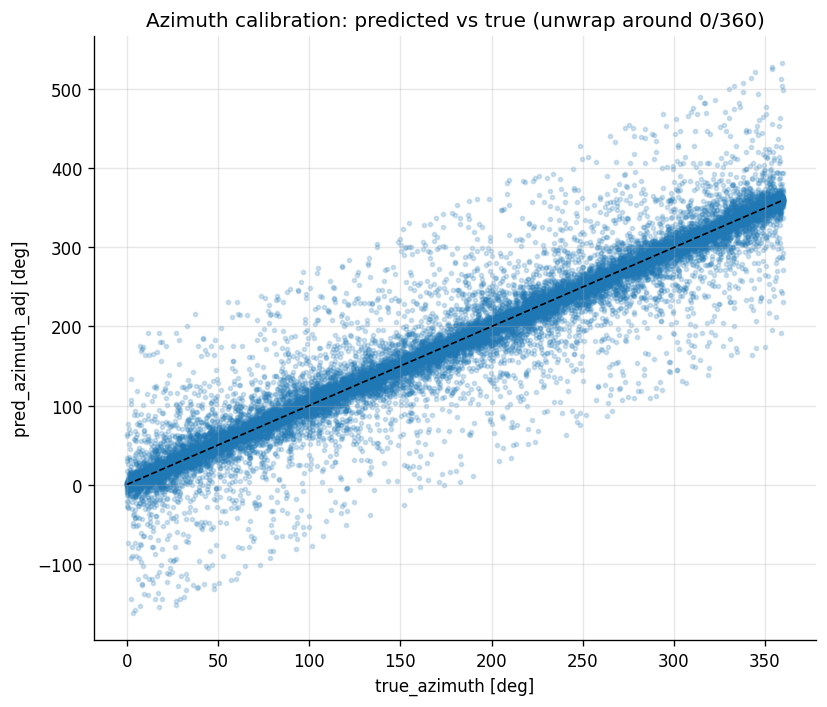

In [140]:
# ---- Azimuth: calibration scatter (UNWRAPPED pred_adj vs true) ----
plt.figure(figsize=(7, 6))

plt.scatter(
    df_azimuth_test_predictions["true_azimuth_degree"],
    df_azimuth_test_predictions["pred_azimuth_degree_adj"],
    s=6, alpha=0.2
)

xmin = df_azimuth_test_predictions["true_azimuth_degree"].min()
xmax = df_azimuth_test_predictions["true_azimuth_degree"].max()

plt.plot([xmin, xmax], [xmin, xmax], color="black", linestyle="--", linewidth=1)

plt.xlabel("true_azimuth [deg]")
plt.ylabel("pred_azimuth_adj [deg]")
plt.title("Azimuth calibration: predicted vs true (unwrap around 0/360)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 1.8 Resolution vs truth (W)


In [141]:
# ---- Azimuth: W table per azimuth bin (using residual_azimuth in radians) ----

df_azimuth_w_rows = []



# Use histogram edges from your azimuth hist cell:
# counts, edges, patches = plt.hist(...)
# If your variable name is edges_azimuth, replace edges -> edges_azimuth below.
for left, right in zip(edges[:-1], edges[1:]):
    # match matplotlib hist logic: [left, right) except last bin includes right
    if right == edges[-1]:
        mask = (df_azimuth_test_predictions["true_azimuth_degree"] >= left) & (df_azimuth_test_predictions["true_azimuth_degree"] <= right)
    else:
        mask = (df_azimuth_test_predictions["true_azimuth_degree"] >= left) & (df_azimuth_test_predictions["true_azimuth_degree"] < right)

    if r.size == 0:
        continue

    p16, p50, p84 = np.quantile(r, [0.16, 0.50, 0.84])
    W = (p84 - p16) / 2
    center = 0.5 * (left + right)

    df_azimuth_w_rows.append({
        "Abin": f"({left:.3f}, {right:.3f}]",
        "A_center_deg": center,
        "count": int(r.size),
        "p16": p16,
        "p50": p50,
        "p84": p84,
        "W": W,  # radians
    })

df_azimuth_W_table = pd.DataFrame(df_azimuth_w_rows)
df_azimuth_W_table


,Abin,A_center_deg,count,p16,p50,p84,W
0,"(0.000, 35.999]",17.999693,41311,-5.928878,-0.146193,5.658621,5.793749
1,"(35.999, 71.998]",53.998514,41311,-5.928878,-0.146193,5.658621,5.793749
2,"(71.998, 107.997]",89.997335,41311,-5.928878,-0.146193,5.658621,5.793749
3,"(107.997, 143.996]",125.996156,41311,-5.928878,-0.146193,5.658621,5.793749
4,"(143.996, 179.994]",161.994978,41311,-5.928878,-0.146193,5.658621,5.793749
5,"(179.994, 215.993]",197.993799,41311,-5.928878,-0.146193,5.658621,5.793749
6,"(215.993, 251.992]",233.992620,41311,-5.928878,-0.146193,5.658621,5.793749
7,"(251.992, 287.991]",269.991442,41311,-5.928878,-0.146193,5.658621,5.793749
8,"(287.991, 323.990]",305.990263,41311,-5.928878,-0.146193,5.658621,5.793749
9,"(323.990, 359.988]",341.989084,41311,-5.928878,-0.146193,5.658621,5.793749


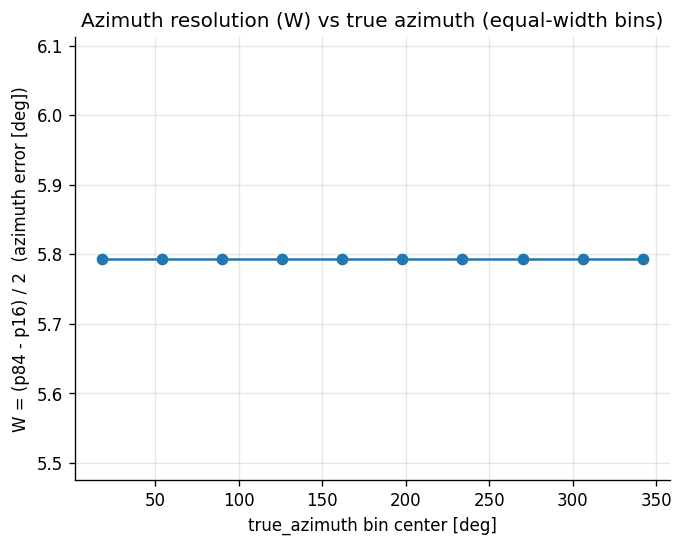

In [142]:
# ---- Azimuth: plot W vs true azimuth (equal-width bins) ----

plt.figure()
plt.plot(df_azimuth_W_table["A_center_deg"], df_azimuth_W_table["W"], marker="o")
plt.xlabel("true_azimuth bin center [deg]")
plt.ylabel("W = (p84 - p16) / 2  (azimuth error [deg])")
plt.title("Azimuth resolution (W) vs true azimuth (equal-width bins)")
plt.grid(True, alpha=0.3)
plt.show()



In the **equal-width** zenith binning, the number of events per bin may not be **uniform** (see section 1.4).  
Depending on the underlying event distribution, some azimuth regions may contain **fewer events**, so the quantile estimates (p16/p50/p84) become **statistically unstable**. This can artificially inflate the width  
$W = (p84 - p16)/2$ and make it look like the resolution worsens in those azimuth ranges.

To reduce this sampling effect, we next repeat the same analysis using **equal-population bins** (i.e., bins with approximately the same number of events) and compare the results.


In [143]:
# ---- create equal-population bins (qcut) ----

n_qbins_azimuth = 10

df_azimuth_test_predictions["Abin_q"] = pd.qcut(
    df_azimuth_test_predictions["true_azimuth_degree"],
    q=n_qbins_azimuth,
    duplicates="drop",
)


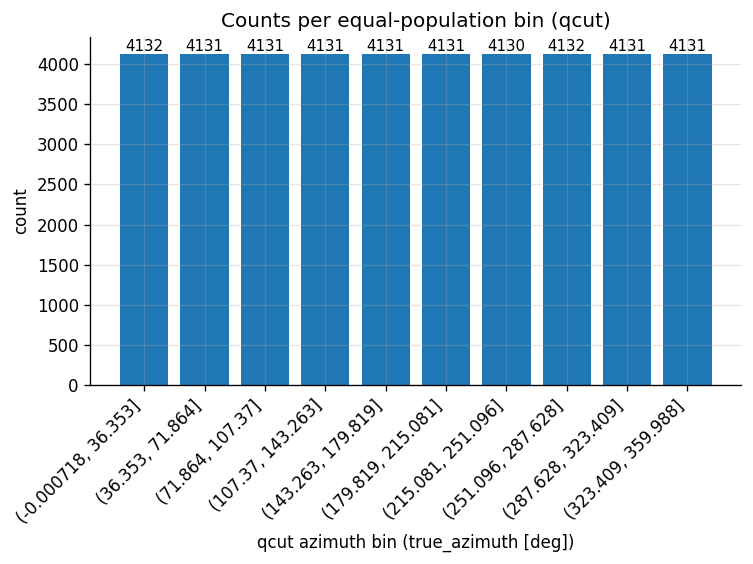

In [144]:
# ---- plot counts per qcut bin ----

bin_counts_q = df_azimuth_test_predictions["Abin_q"].value_counts().sort_index()

plt.figure()
plt.bar(range(len(bin_counts_q)), bin_counts_q.to_numpy())
plt.xticks(
    range(len(bin_counts_q)),
    [str(i) for i in bin_counts_q.index],
    rotation=45,
    ha="right",
)
plt.xlabel("qcut azimuth bin (true_azimuth [deg])")
plt.ylabel("count")
plt.title("Counts per equal-population bin (qcut)")
plt.grid(True, axis="y", alpha=0.3)

# annotate counts on top of bars
for i, c in enumerate(bin_counts_q.to_numpy()):
    plt.text(i, c, str(int(c)), ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()


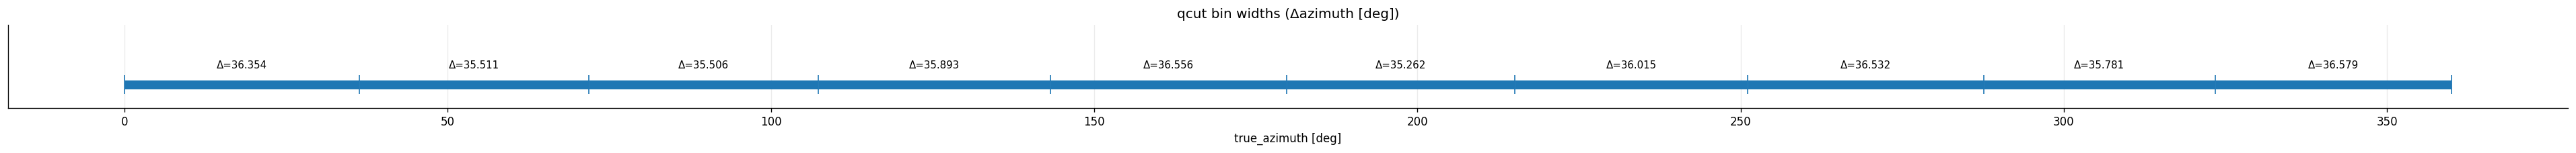

In [145]:
# ---- Visualize qcut bin widths only (in azimuth radian space) ----

# intervals in correct order
intervals = bin_counts_q.index  # IntervalIndex from your existing bin_counts_q

lefts  = np.array([iv.left for iv in intervals], dtype=float)
rights = np.array([iv.right for iv in intervals], dtype=float)
widths = rights - lefts
centers = (lefts + rights) / 2

plt.figure(figsize=(32, 2))

# draw each bin as a horizontal segment
for L, R, w, x in zip(lefts, rights, widths, centers):
    plt.hlines(0, L, R, linewidth=8)
    plt.text(x, 0.12, f"Δ={w:.3f}", ha="center", va="bottom", fontsize=9)

# draw bin boundaries as small ticks
for x in lefts:
    plt.vlines(x, -0.08, 0.08, linewidth=1)
plt.vlines(rights[-1], -0.08, 0.08, linewidth=1)

plt.yticks([])
plt.xlabel("true_azimuth [deg]")
plt.title("qcut bin widths (Δazimuth [deg])")
plt.ylim(-0.2, 0.5)
plt.tight_layout()
plt.show()


In [146]:
# ---- Azimuth: p16/p50/p84 and W per qcut bin (use groupby directly; no remasking) ----

rows_azimuth_q = []
for iv, g in df_azimuth_test_predictions.groupby("Abin_q", observed=True):
    r = (g["pred_azimuth_degree"] - g["true_azimuth_degree"]).to_numpy(dtype=float)  # residual in radians

    p16, p50, p84 = np.quantile(r, [0.16, 0.50, 0.84])
    W = (p84 - p16) / 2
    center = 0.5 * (float(iv.left) + float(iv.right))

    rows_azimuth_q.append({
        "Abin_q": str(iv),
        "A_center_deg": center,
        "count": int(len(g)),
        "p16": p16,
        "p50": p50,
        "p84": p84,
        "W": W,  # radians
    })

df_azimuth_W_table_q = pd.DataFrame(rows_azimuth_q).sort_values("A_center_deg")
df_azimuth_W_table_q


,Abin_q,A_center_deg,count,p16,p50,p84,W
0,"(-0.000718, 36.353]",18.176141,4132,-2.428824,1.041827,23.549952,12.989388
1,"(36.353, 71.864]",54.108500,4131,-3.898129,0.714989,8.267589,6.082859
2,"(71.864, 107.37]",89.617000,4131,-3.748721,0.616684,7.510747,5.629734
3,"(107.37, 143.263]",125.316500,4131,-5.458316,-0.159241,5.722166,5.590241
4,"(143.263, 179.819]",161.541000,4131,-6.232529,-0.712067,4.448239,5.340384
5,"(179.819, 215.081]",197.450000,4131,-6.973593,-0.809586,4.442572,5.708083
6,"(215.081, 251.096]",233.088500,4130,-7.128029,-1.365479,4.810195,5.969112
7,"(251.096, 287.628]",269.362000,4132,-7.237234,-0.488098,4.288234,5.762734
8,"(287.628, 323.409]",305.518500,4131,-7.597137,-0.048737,4.720819,6.158978
9,"(323.409, 359.988]",341.698500,4131,-22.321326,-0.364258,3.295551,12.808438


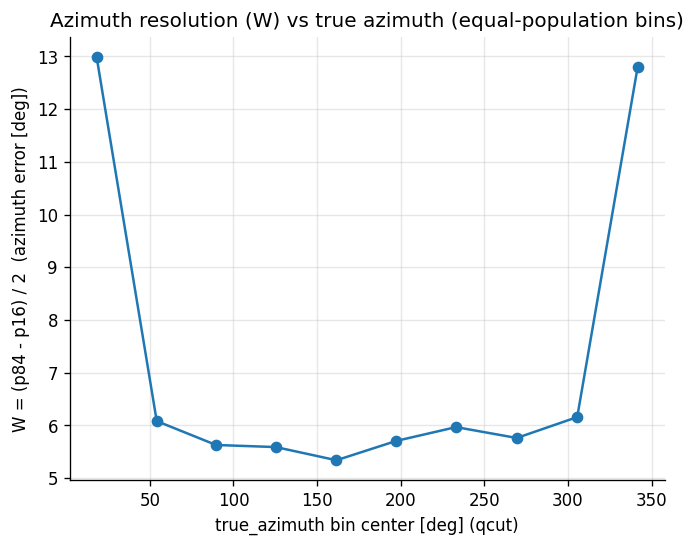

In [147]:
# ---- Azimuth: plot W vs true azimuth (qcut bins) ----

plt.figure()
plt.plot(df_azimuth_W_table_q["A_center_deg"], df_azimuth_W_table_q["W"], marker="o")
plt.xlabel("true_azimuth bin center [deg] (qcut)")
plt.ylabel("W = (p84 - p16) / 2  (azimuth error [deg])")
plt.title("Azimuth resolution (W) vs true azimuth (equal-population bins)")
plt.grid(True, alpha=0.3)
plt.show()


## 1.9 Bias diagnostics: two approaches


### 1.9.1

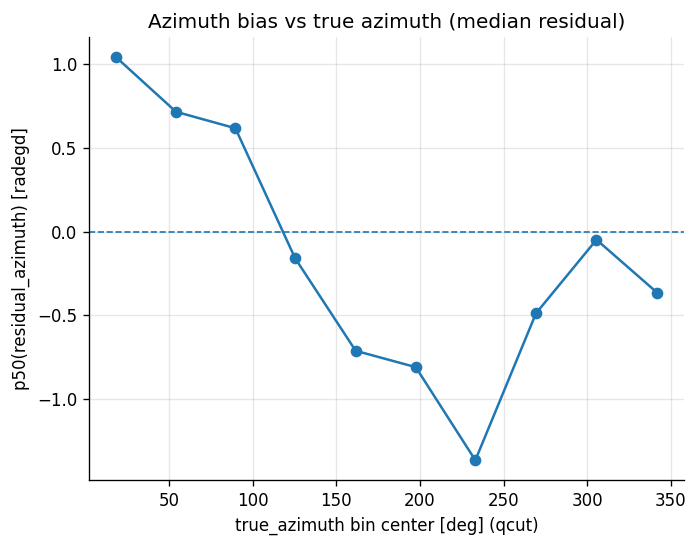

In [148]:
# ---- Azimuth: bias vs true azimuth (median residual, qcut bins) ----

plt.figure()
plt.plot(df_azimuth_W_table_q["A_center_deg"], df_azimuth_W_table_q["p50"], marker="o")
plt.axhline(0.0, linestyle="--", linewidth=1)
plt.xlabel("true_azimuth bin center [deg] (qcut)")
plt.ylabel("p50(residual_azimuth) [radegd]")
plt.title("Azimuth bias vs true azimuth (median residual)")
plt.grid(True, alpha=0.3)
plt.show()


### 1.9.2

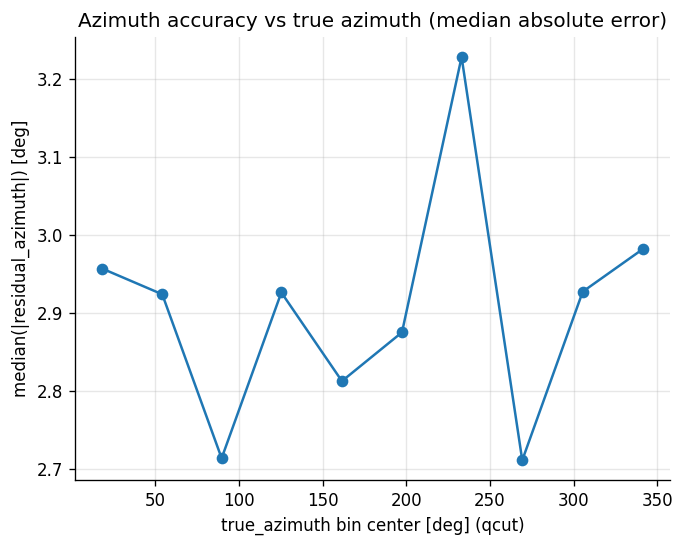

In [149]:
# ---- Azimuth: median absolute error vs true azimuth (qcut bins) ----

df_azimuth_W_table_q["abs_p50_deg"] = np.nan  # keep style similar to your energy table edits

abs_rows = []
for iv, g in df_azimuth_test_predictions.groupby("Abin_q", observed=True):
    r = (g["pred_azimuth_degree"] - g["true_azimuth_degree"]).to_numpy(dtype=float)
    abs_rows.append((str(iv), np.median(np.abs(r))))

abs_map = dict(abs_rows)
df_azimuth_W_table_q["abs_p50_deg"] = df_azimuth_W_table_q["Abin_q"].map(abs_map)

plt.figure()
plt.plot(df_azimuth_W_table_q["A_center_deg"], df_azimuth_W_table_q["abs_p50_deg"], marker="o")
plt.xlabel("true_azimuth bin center [deg] (qcut)")
plt.ylabel("median(|residual_azimuth|) [deg]")
plt.title("Azimuth accuracy vs true azimuth (median absolute error)")
plt.grid(True, alpha=0.3)
plt.show()


# 2. Training Metrics (epoch-level)


## 2.1 Overview


In [150]:
print("shape:", df_azimuth_metrics.shape)
print("columns:", list(df_azimuth_metrics.columns))


shape: (27, 13)
columns: ['epoch', 'train_loss', 'val_loss', 'lr', 'best_model_is_updated', 'val_residual_p16_deg', 'val_residual_p50_deg', 'val_residual_p84_deg', 'val_W_deg', 'val_kappa_p16', 'val_kappa_p50', 'val_kappa_p84', 'val_kappa_W']


In [151]:
# Identify the epoch where the best model was last updated
if "best_model_is_updated" in df_azimuth_metrics.columns:
    _mask = df_azimuth_metrics["best_model_is_updated"].astype(bool)
    best_epoch = int(df_azimuth_metrics.loc[_mask, "epoch"].max()) if _mask.any() else None
else:
    best_epoch = None

print(f"Best-model epoch (last update): {best_epoch}")


Best-model epoch (last update): 21


In [152]:
df_azimuth_metrics.head(5)


,epoch,train_loss,val_loss,lr,best_model_is_updated,val_residual_p16_deg,val_residual_p50_deg,val_residual_p84_deg,val_W_deg,val_kappa_p16,val_kappa_p50,val_kappa_p84,val_kappa_W
0,0,NaN,0.085779,0.000983,True,-11.433356,0.777139,12.043907,11.738632,4.052917,18.891928,48.633694,22.290388
1,1,0.764658,-0.236279,0.000950,True,-8.151605,0.621370,9.823856,8.987730,4.918227,32.615459,81.969444,38.525608
2,2,-0.162389,-0.309017,0.000916,True,-7.897096,0.623992,9.330848,8.613972,4.663252,41.684303,86.622620,40.979683
3,3,-0.293951,-0.357178,0.000883,True,-8.451591,-0.287305,7.891946,8.171768,5.500217,53.160690,97.342072,45.920929
4,4,-0.347391,-0.381400,0.000849,True,-8.160834,-0.049970,8.162884,8.161860,5.580246,54.331291,91.680344,43.050049


## 2.2 Training curves (loss & LR)


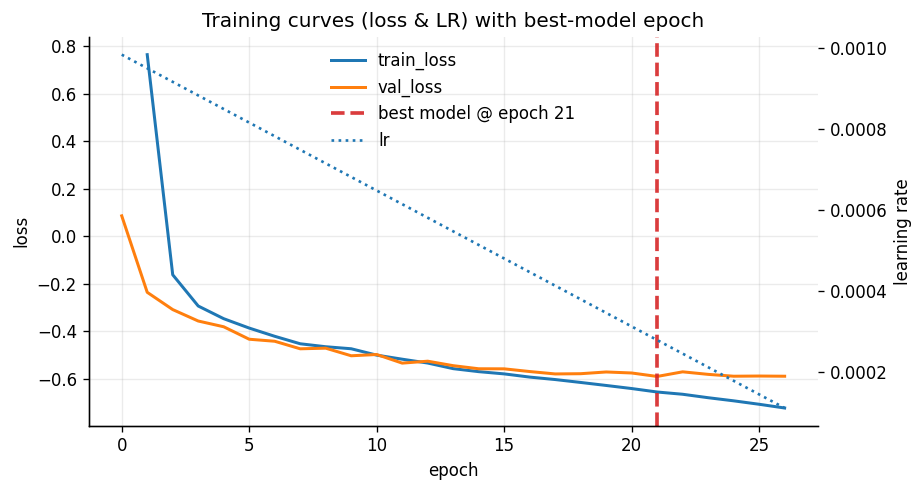

In [153]:
fig, ax = plt.subplots(figsize=(7.8, 4.2))

ax.plot(df_azimuth_metrics["epoch"], df_azimuth_metrics["train_loss"], label="train_loss", linewidth=1.8)
ax.plot(df_azimuth_metrics["epoch"], df_azimuth_metrics["val_loss"], label="val_loss", linewidth=1.8)

# Best-model epoch (last update)
if "best_model_is_updated" in df_azimuth_metrics.columns:
    _mask = df_azimuth_metrics["best_model_is_updated"].astype(bool)
    _best_epoch = int(df_azimuth_metrics.loc[_mask, "epoch"].max()) if _mask.any() else None
else:
    _best_epoch = None

if _best_epoch is not None:
    ax.axvline(
        _best_epoch,
        color="tab:red",
        linestyle="--",
        linewidth=2.2,
        alpha=0.9,
        label=f"best model @ epoch {_best_epoch}",
    )

ax.set_xlabel("epoch")
ax.set_ylabel("loss")

ax2 = None
if "lr" in df_azimuth_metrics.columns:
    ax2 = ax.twinx()
    ax2.plot(df_azimuth_metrics["epoch"], df_azimuth_metrics["lr"], label="lr", linestyle=":", linewidth=1.6)
    ax2.set_ylabel("learning rate")
    ax2.grid(False)

# Combined legend
handles, labels = ax.get_legend_handles_labels()
if ax2 is not None:
    h2, l2 = ax2.get_legend_handles_labels()
    handles += h2
    labels += l2
ax.legend(handles, labels, loc="best")

ax.set_title("Training curves (loss & LR) with best-model epoch")
fig.tight_layout()
plt.show()


## 2.3 Key validation metrics over epochs


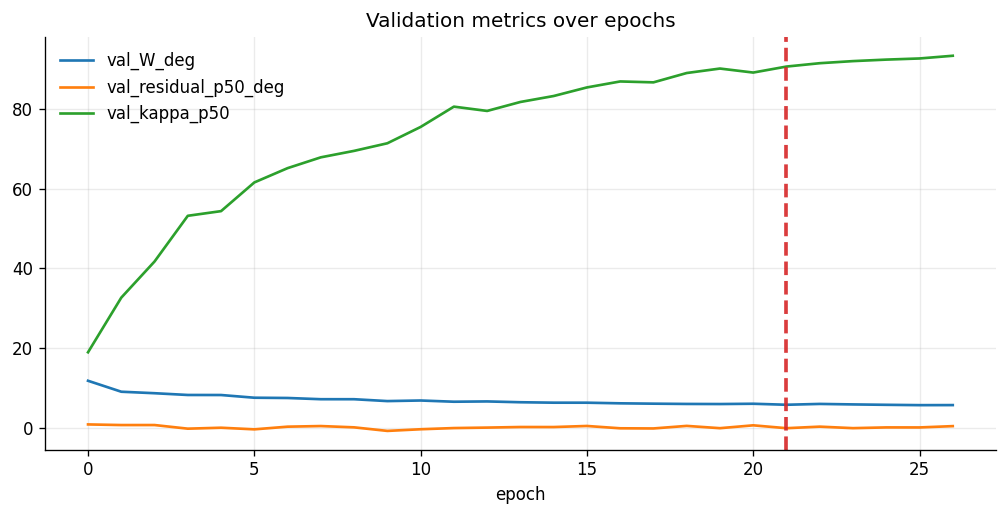

In [154]:
# Key validation metrics over epochs (from metrics.csv)
cols_to_plot = ["val_W_deg", "val_residual_p50_deg", "val_kappa_p50"]
cols_to_plot = [c for c in cols_to_plot if c in df_azimuth_metrics.columns]

plt.figure(figsize=(8.5, 4.4))
for col in cols_to_plot:
    plt.plot(df_azimuth_metrics["epoch"], df_azimuth_metrics[col], label=col, linewidth=1.6)

if "best_model_is_updated" in df_azimuth_metrics.columns:
    _mask = df_azimuth_metrics["best_model_is_updated"].astype(bool)
    _best_epoch = int(df_azimuth_metrics.loc[_mask, "epoch"].max()) if _mask.any() else None
    if _best_epoch is not None:
        plt.axvline(_best_epoch, color="tab:red", linestyle="--", linewidth=2.2, alpha=0.9)

plt.xlabel("epoch")
plt.title("Validation metrics over epochs")
plt.legend(loc="best")
plt.tight_layout()
plt.show()


## 2.4 Snapshot (best vs last epoch)


In [155]:
# Best-epoch vs last-epoch snapshot (epoch-level metrics)
_last = df_azimuth_metrics.tail(1).copy()
_last.insert(0, "which", "last_epoch")

if best_epoch is not None:
    _best = df_azimuth_metrics.loc[df_azimuth_metrics["epoch"] == best_epoch].tail(1).copy()
    _best.insert(0, "which", "best_epoch")
    snapshot = pd.concat([_best, _last], ignore_index=True)
else:
    snapshot = _last

snapshot


,which,epoch,train_loss,val_loss,lr,best_model_is_updated,val_residual_p16_deg,val_residual_p50_deg,val_residual_p84_deg,val_W_deg,val_kappa_p16,val_kappa_p50,val_kappa_p84,val_kappa_W
0,best_epoch,21,-0.656172,-0.590652,0.000278,True,-5.827751,-0.167463,5.602339,5.715045,12.023890,90.62793,100.548820,44.262466
1,last_epoch,26,-0.723533,-0.589717,0.000111,False,-5.343016,0.350170,5.922121,5.632568,13.556664,93.34095,101.658043,44.050690


# 3. Resource and Time Information (epoch-level)


## 3.1 What this file captures



`resources_and_time.csv` is written **once per epoch** (at the end of validation, via the callback).  
Each row is a **snapshot at an epoch boundary**, not a continuous measurement.

**Implications**
- `epoch_duration_min` is a good proxy for *epoch wall time* (train + val).
- `gpu_util_pct` can be **0% even if the GPU was busy earlier** in the epoch (because it is sampled at the end).
- `sys_mem_used_gb` and `cpu_load_pct` reflect **node-level** state and can be influenced by other processes on the same node.


## 3.2 Quick view and sanity checks

In [156]:
df_azimuth_resources_and_time.head(5)


,epoch,elapsed_min,epoch_duration_min,rss_gb,sys_mem_used_gb,cpu_load_pct,gpu_util_pct,gpu_mem_used_gb,gpu_mem_total_gb,gpu_mem_util_pct
0,0,21.016,21.016,2.118,70.219,56.04,80.0,30.526,79.647,38.3
1,1,40.236,19.220,2.118,70.071,67.05,0.0,36.573,79.647,45.9
2,2,59.437,19.201,2.117,70.153,63.12,0.0,36.573,79.647,45.9
3,3,78.999,19.562,2.100,70.611,61.23,0.0,36.573,79.647,45.9
4,4,98.345,19.345,2.101,70.763,73.56,0.0,36.573,79.647,45.9


In [157]:
print("Shape:", df_azimuth_resources_and_time.shape)
print("\nDtypes:")
print(df_azimuth_resources_and_time.dtypes)

print("\nMissing values per column:")
print(df_azimuth_resources_and_time.isna().sum())

elapsed = pd.to_numeric(df_azimuth_resources_and_time["elapsed_min"], errors="coerce")
print("\nElapsed monotonic increasing:", elapsed.is_monotonic_increasing)

Shape: (27, 10)

Dtypes:
epoch                   int64
elapsed_min           float64
epoch_duration_min    float64
rss_gb                float64
sys_mem_used_gb       float64
cpu_load_pct          float64
gpu_util_pct          float64
gpu_mem_used_gb       float64
gpu_mem_total_gb      float64
gpu_mem_util_pct      float64
dtype: object

Missing values per column:
epoch                 0
elapsed_min           0
epoch_duration_min    0
rss_gb                0
sys_mem_used_gb       0
cpu_load_pct          0
gpu_util_pct          0
gpu_mem_used_gb       0
gpu_mem_total_gb      0
gpu_mem_util_pct      0
dtype: int64

Elapsed monotonic increasing: True


## 3.3 Timeline: elapsed time and epoch duration



Two independent ways to estimate epoch duration:
- `epoch_duration_min` (logged)
- `diff(elapsed_min)` (derived)


In [158]:
def _num(col: str):
    """Read a numeric column without modifying the original dataframe."""
    return pd.to_numeric(df_azimuth_resources_and_time[col], errors="coerce")

epoch = _num("epoch")
elapsed = _num("elapsed_min")
epoch_dur_logged = _num("epoch_duration_min")
epoch_dur_from_elapsed = elapsed.diff()

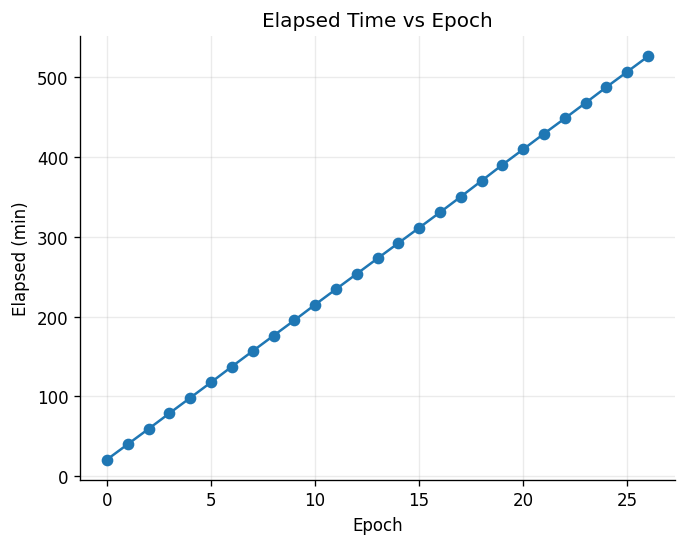

In [159]:
fig, ax = plt.subplots()
ax.plot(epoch, elapsed, marker="o")
ax.set_title("Elapsed Time vs Epoch")
ax.set_xlabel("Epoch")
ax.set_ylabel("Elapsed (min)")
plt.show()

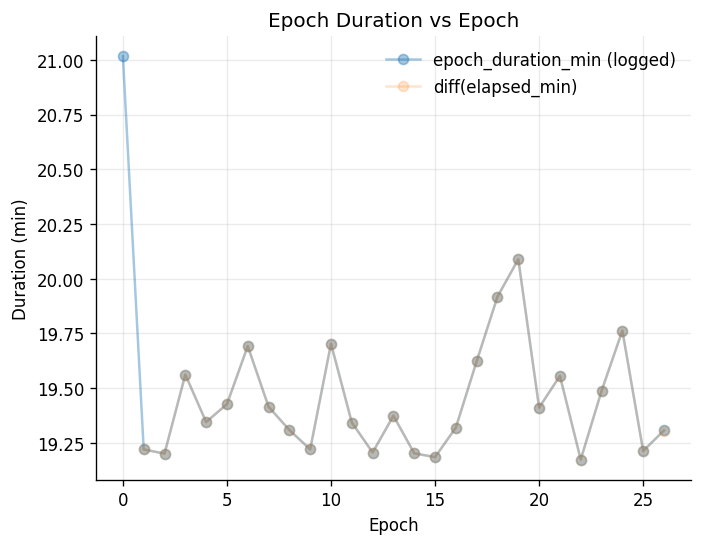

In [160]:
fig, ax = plt.subplots()
ax.plot(epoch, epoch_dur_logged, marker="o", label="epoch_duration_min (logged)", alpha=0.4)
ax.plot(epoch, epoch_dur_from_elapsed, marker="o", label="diff(elapsed_min)", alpha=0.2)
ax.set_title("Epoch Duration vs Epoch")
ax.set_xlabel("Epoch")
ax.set_ylabel("Duration (min)")
ax.legend()
plt.show()

In [161]:
dur = epoch_dur_logged.dropna()
total_time_min = float(elapsed.dropna().iloc[-1]) if elapsed.notna().any() else np.nan

print(f"Total elapsed (min): {total_time_min:.3f}")
print(
    "Epoch duration (min) | "
    f"mean={dur.mean():.3f}, std={dur.std(ddof=1):.3f}, "
    f"min={dur.min():.3f}, max={dur.max():.3f}"
)

slow_idx = epoch_dur_logged.nlargest(5).index
df_azimuth_resources_and_time.loc[slow_idx, [
    "epoch", "epoch_duration_min", "cpu_load_pct", "gpu_util_pct",
    "gpu_mem_used_gb", "gpu_mem_util_pct", "rss_gb"
]]

Total elapsed (min): 526.280
Epoch duration (min) | mean=19.492, std=0.387, min=19.174, max=21.016


,epoch,epoch_duration_min,cpu_load_pct,gpu_util_pct,gpu_mem_used_gb,gpu_mem_util_pct,rss_gb
0,0,21.016,56.04,80.0,30.526,38.3,2.118
19,19,20.089,82.49,64.0,36.573,45.9,2.034
18,18,19.918,81.42,0.0,36.573,45.9,2.025
24,24,19.763,56.91,0.0,36.575,45.9,2.034
10,10,19.703,56.38,0.0,36.573,45.9,2.099


## 3.4 Resource curves (epoch-boundary snapshots)



The following plots help answer:
- **Is the run GPU-bound or input/CPU-bound?**
- **Is GPU memory saturated (batch size too large)?**
- **Is RAM growing (potential leak / caching effect)?**


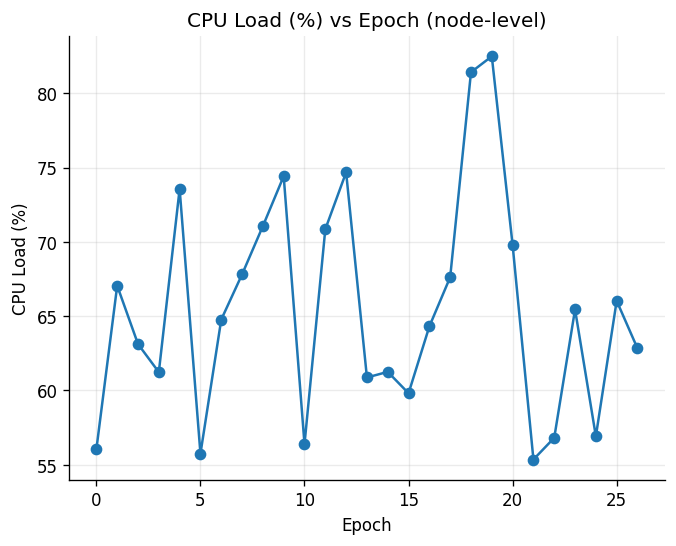

In [162]:
cpu = _num("cpu_load_pct")
fig, ax = plt.subplots()
ax.plot(epoch, cpu, marker="o")
ax.set_title("CPU Load (%) vs Epoch (node-level)")
ax.set_xlabel("Epoch")
ax.set_ylabel("CPU Load (%)")
plt.show()

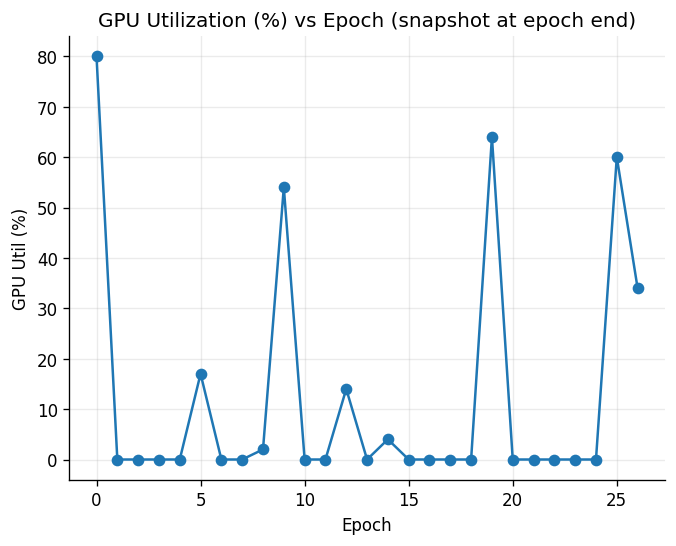

In [163]:
gpu_util = _num("gpu_util_pct")
fig, ax = plt.subplots()
ax.plot(epoch, gpu_util, marker="o")
ax.set_title("GPU Utilization (%) vs Epoch (snapshot at epoch end)")
ax.set_xlabel("Epoch")
ax.set_ylabel("GPU Util (%)")
plt.show()

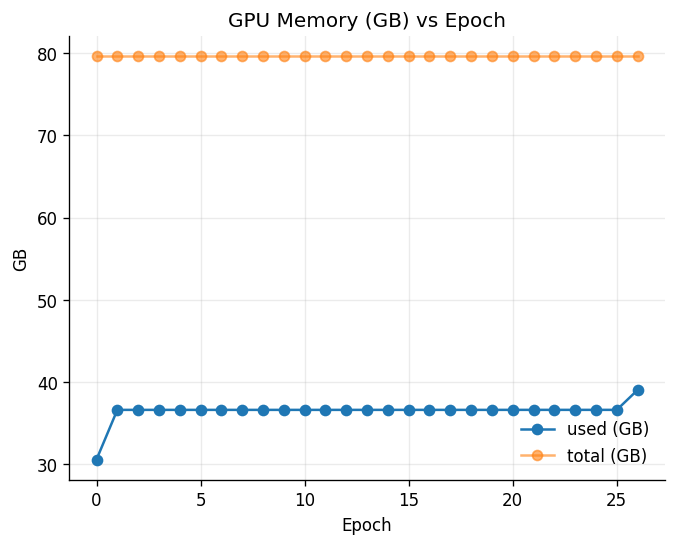

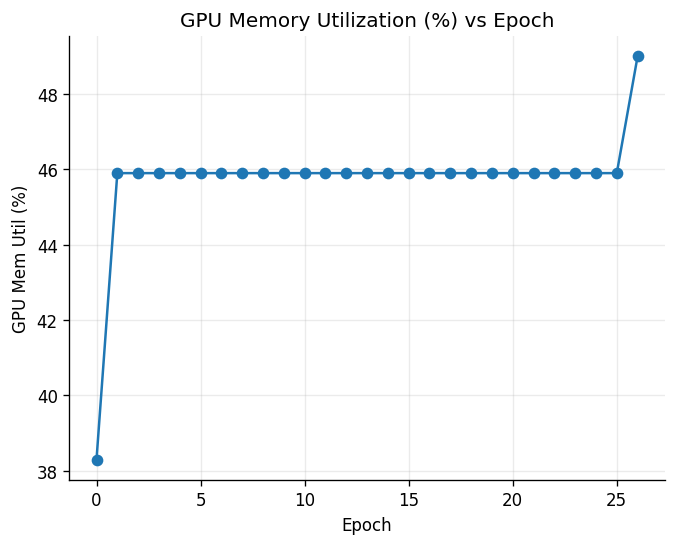

In [164]:
gpu_mem_used = _num("gpu_mem_used_gb")
gpu_mem_total = _num("gpu_mem_total_gb")
gpu_mem_util = _num("gpu_mem_util_pct")

fig, ax = plt.subplots()
ax.plot(epoch, gpu_mem_used, marker="o", label="used (GB)")
ax.plot(epoch, gpu_mem_total, marker="o", label="total (GB)", alpha=0.6)
ax.set_title("GPU Memory (GB) vs Epoch")
ax.set_xlabel("Epoch")
ax.set_ylabel("GB")
ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(epoch, gpu_mem_util, marker="o")
ax.set_title("GPU Memory Utilization (%) vs Epoch")
ax.set_xlabel("Epoch")
ax.set_ylabel("GPU Mem Util (%)")
plt.show()

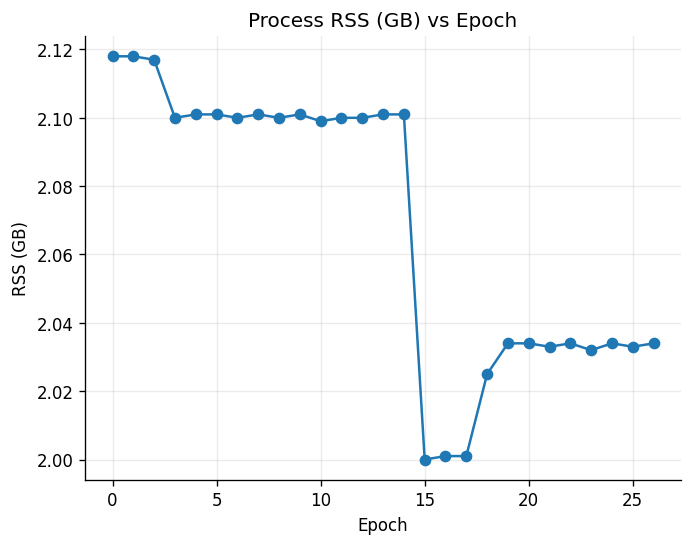

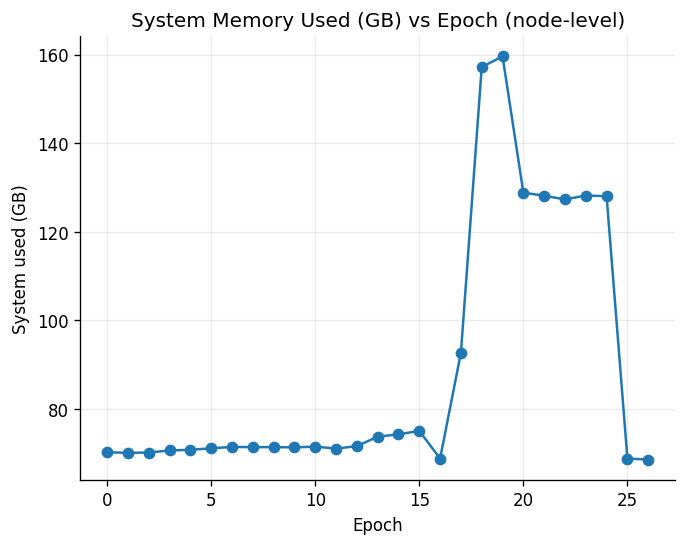

In [165]:
rss = _num("rss_gb")
sys_mem = _num("sys_mem_used_gb")

fig, ax = plt.subplots()
ax.plot(epoch, rss, marker="o")
ax.set_title("Process RSS (GB) vs Epoch")
ax.set_xlabel("Epoch")
ax.set_ylabel("RSS (GB)")
plt.show()

fig, ax = plt.subplots()
ax.plot(epoch, sys_mem, marker="o")
ax.set_title("System Memory Used (GB) vs Epoch (node-level)")
ax.set_xlabel("Epoch")
ax.set_ylabel("System used (GB)")
plt.show()

## 3.5 Bottleneck heuristics



These are **heuristics**, not proofs—because the metrics are snapshots.  
Still, they help you decide what to tweak (batch size, num_workers, prefetch, etc.).


In [166]:
# Simple flags (tunable thresholds)
gpu_idle_mask = _num("gpu_util_pct").fillna(0) < 1.0
cpu_high_mask = _num("cpu_load_pct").fillna(0) > 90.0
slow_mask = epoch_dur_logged >= epoch_dur_logged.quantile(0.90)

mask = gpu_idle_mask | cpu_high_mask | slow_mask

cols = [
    "epoch", "epoch_duration_min",
    "cpu_load_pct", "gpu_util_pct",
    "gpu_mem_used_gb", "gpu_mem_util_pct",
    "rss_gb", "sys_mem_used_gb",
]
df_azimuth_resources_and_time.loc[mask, cols].sort_values("epoch")

,epoch,epoch_duration_min,cpu_load_pct,gpu_util_pct,gpu_mem_used_gb,gpu_mem_util_pct,rss_gb,sys_mem_used_gb
0,0,21.016,56.04,80.0,30.526,38.3,2.118,70.219
1,1,19.220,67.05,0.0,36.573,45.9,2.118,70.071
2,2,19.201,63.12,0.0,36.573,45.9,2.117,70.153
3,3,19.562,61.23,0.0,36.573,45.9,2.100,70.611
4,4,19.345,73.56,0.0,36.573,45.9,2.101,70.763
6,6,19.692,64.77,0.0,36.573,45.9,2.100,71.414
7,7,19.415,67.81,0.0,36.573,45.9,2.101,71.366
10,10,19.703,56.38,0.0,36.573,45.9,2.099,71.481
11,11,19.343,70.85,0.0,36.573,45.9,2.100,71.033
13,13,19.374,60.87,0.0,36.573,45.9,2.101,73.725


In [167]:
# Correlations with epoch duration (numeric view; does NOT modify df)
metrics = [
    "cpu_load_pct", "gpu_util_pct",
    "gpu_mem_used_gb", "gpu_mem_util_pct",
    "rss_gb", "sys_mem_used_gb",
]
X = pd.concat([epoch_dur_logged.rename("epoch_duration_min")] + [_num(m).rename(m) for m in metrics], axis=1)
corr_to_dur = X.corr(numeric_only=True)["epoch_duration_min"].drop("epoch_duration_min").sort_values(ascending=False)

print("Correlation with epoch_duration_min (higher => tends to increase duration):")
corr_to_dur

Correlation with epoch_duration_min (higher => tends to increase duration):


gpu_util_pct        0.485015
sys_mem_used_gb     0.287827
rss_gb              0.036166
cpu_load_pct       -0.044621
gpu_mem_util_pct   -0.755324
gpu_mem_used_gb    -0.756706
Name: epoch_duration_min, dtype: float64

## 3.6 How to act on what you see (practical checklist)



**If GPU util is often low while CPU load is high**
- Data pipeline is likely the bottleneck → increase `num_workers`, enable `pin_memory`, `persistent_workers`,
  adjust `prefetch_factor`, consider faster storage / caching, avoid heavy Python transforms per batch.

**If GPU memory is close to full**
- Reduce `batch_size` (or model size), consider gradient accumulation instead of huge batches.

**If GPU memory is stable but epoch duration increases**
- Check for CPU/RAM pressure, background jobs on the same node, or increasing dataloader overhead.

**If process RSS grows steadily**
- Possible memory leak or accumulating caches → inspect dataloader caching, repeated object creation,
  and keep an eye on Python lists that grow across epochs.
